In [23]:
import numpy as np


# 弱分類器（切り株）の実装
class DecisionStump():
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    # threshold を境に、-1,1のいずれかの予測を行う
    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1
        return predictions


class Adaboost():

    # n_clfは、繰り返す回数を表している
    def __init__(self, n_clf=5):
        self.n_clf = n_clf
        self.test_predicts = []
        self.train_predicts = []

    # -1を1に、1を0に変換する指示関数
    def transform(self, predictions, y):
        indicator = []
        for i in range(len(predictions)):
            if predictions[i] == y[i]:
                indicator.append(0)
            else:
                indicator.append(1)
        return indicator

    def fit(self, X, y,X_test):
        n_samples, n_features = X.shape

        # 重みの初期値を1/N(i=1,2,...,N)に設定
        w = np.full(n_samples, (1/n_samples))

        self.clfs = []   

        for _ in range(self.n_clf):
            clf = DecisionStump()

            min_error = float('inf')

            # 最も誤分類の少ない、ある特徴量におけるしきい値を求める
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    polarity = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    misclassified = w[y != predictions]
                    # errorは、2(b)の分子（分母は正規化して1としているので無視して良い）
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        polarity = -1

                    if error < min_error:
                        clf.polarity = polarity
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            EPS = 1e-10
            clf.alpha = np.log((1.0 - min_error + EPS) / (min_error + EPS))

            predictions = clf.predict(X)

            indicator = np.array(self.transform(predictions, y))
            # 誤分類した観測値の重みを増す
            w *= np.exp(clf.alpha * indicator)

            # wの合計を1に正規化
            w /= np.sum(w)
            
            self.clfs.append(clf)
            
            self.test_predicts.append(self.predict(X_test))
            self.train_predicts.append(self.predict(X))
            
     # alphaで重み付けして、符合関数で予測
    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)
        return y_pred

In [20]:
#シード値を固定
np.random.seed(0)

#標準正規分布に従う乱数を12000個発生
X = np.random.randn(12000,10)

In [21]:
#正解ラベル作成
def generateLabel(X):
    y = []
    for i in range(X.shape[0]):
        squaredX = [ j**2 for j in X[i]]
        #10自由度のカイ二乗分布に従う確率変数の中央値より大きいか否かで判定
        if sum(squaredX) > 9.34:
            y.append(1)
        else:
            y.append(-1)
    return y

y = generateLabel(X)

In [22]:
X_train = X[0:2000]
X_test = X[2000:12000]
y_train = y[0:2000]
y_test = y[2000:12000]

In [14]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from adaboost import Adaboost

def misclassificationRate(y_true, y_pred):
    miss_rate =  1- np.sum(y_true == y_pred) / len(y_true)
    return miss_rate

# 単独の切り株の場合
clf = Adaboost(n_clf=1)
clf.fit(X_train, y_train,X_test)
y_pred = clf.predict(X_test)

miss_rate = misclassificationRate(y_test, y_pred)
print("誤分類率:", miss_rate)

誤分類率: 0.45840000000000003


In [24]:
# 400回繰り返した場合
clf = Adaboost(n_clf=400)
clf.fit(X_train, y_train,X_test)
y_pred = clf.predict(X_test)

miss_rate = misclassificationRate(y_test, y_pred)
print("誤分類率:", miss_rate)

誤分類率: 0.1362


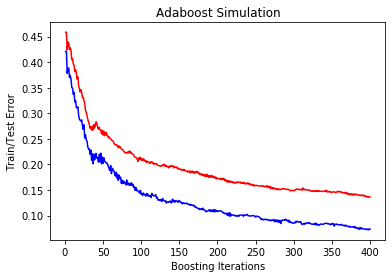

In [28]:
def misclassificationRate(y_true, y_pred):
    miss_rate =  1- np.sum(y_true == y_pred) / len(y_true)
    return miss_rate

test_results = []
train_results = []

for i in range(clf.n_clf):
    test_miss_rate = misclassificationRate(y_test,clf.test_predicts[i])
    train_miss_rate = misclassificationRate(y_train,clf.train_predicts[i])
    test_results.append(test_miss_rate)
    train_results.append(train_miss_rate)
    
import matplotlib.pyplot as plt
x_axis = list(range(1,len(results)+1))
plt.plot(x_axis,test_results,color="red")
plt.plot(x_axis,train_results, color="blue")

plt.title('Adaboost Simulation')
plt.xlabel('Boosting Iterations')
plt.ylabel('Train/Test Error')

plt.show()